In [1]:
from hyp_solver3 import HypProblem, Mesh, Solver, solve_oc
import matplotlib.pyplot as plt
import numpy as np
import scipy
from time import time

In [2]:
G11_true = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G22_true = lambda t: - (np.sin(t)) / (np.cos(t) - 4* np.sin(t))

x0 = lambda s: 0
y0 = lambda s: (3*s+1)/(2*(s+1))

x_an = lambda s, t: 2*(s**2+1)*np.sin(t)
y_an = lambda s, t: (3*s+1)/(2*(s+1))*np.cos(t)
T = [0, 0.2]
S = [0, 1]
C = [1,2]
# C = [2.3,0.9]

B11 = lambda s, t: -2*s
B12 = lambda s, t: 4/3*s**2
B21 = lambda s, t: - (3*s+1)/(4*(s**2+1)*(s+1))
B22 = lambda s, t: 4/((s+1)*(3*s+1))

G11 = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G12 = lambda t: - G11(t)
G21_ = lambda t: (np.sin(t)) / (np.cos(t) - 4* np.sin(t))
G21 = lambda t: G21_(t) - 1
G22 = lambda t: - G21(t)

F1 = lambda s, t: 4*s**3*np.sin(t)+2*np.cos(t)+4*s**2*np.cos(t)/(3*(s+1))
F2 = lambda s, t: 0

phi_dx = lambda s, x, y : -2*(x - x_an(s, T[1])) 
phi_dy = lambda s, x, y : -2*(y - y_an(s, T[1]))

hyp_problem = HypProblem(T=T, S=S, C=C, B=[[B11, B12], [B21, B22]], 
                         F=[F1, F2], G=[[G11, G12], [G21, G22]], 
                         X0=x0, Y0=y0, phi_dx=phi_dx, phi_dy=phi_dy)

mesh = Mesh(hyp_problem, 100)
solver = Solver()
solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)


In [3]:
def get_rez(oc_problem):
    rez = {}
    nodes = oc_problem.mesh.get_border(type_border="final", sort_s=True)
    s = [node[0][2] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    deltas_x = np.array([abs(xi-x_an(si,T[1])) for si, xi in zip(s, x)])
    deltas_y = np.array([abs(yi-y_an(si,T[1])) for si, yi in zip(s, y)])
    
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    
    v_an = np.array([G22_true(ti) for ti in t])
    v = np.array([oc_problem.hyp_problem.G22(ti) for ti in t])
    deltas_v = np.array([abs(vi-v_ani) for vi, v_ani in zip(v, v_an)])
    rez = {
        "max dx": np.max(deltas_x),
        "max dy": np.max(deltas_y),
        "max dv": np.max(deltas_v),
        "int dx^2 ds": scipy.integrate.trapezoid(deltas_x**2, s),
        "int dy^2 ds": scipy.integrate.trapezoid(deltas_x**2, s),
        "int dv^2 dt": scipy.integrate.trapezoid(deltas_v**2, t)
    }
    return rez

In [4]:
def plot_sys(mesh):
    plt.figure(figsize=(12,6))
    
    nodes = mesh.get_border(type_border="final", sort_s=True)
    s = [node[0][2] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    
    plt.subplot(3, 2, 1)
    plt.plot(s, x, "ro")
    plt.plot(s, [x_an(si, T[1]) for si in s], "b-")
    plt.ylabel("x")
    plt.grid()
    plt.subplot(3, 2, 3)
    plt.plot(s, y, "ro")
    plt.plot(s, [y_an(si, T[1]) for si in s], "b-")
    plt.ylabel("y")
    plt.xlabel("s")
    plt.grid()

    deltas_x = [abs(xi-x_an(si,T[1])) for si, xi in zip(s, x)]
    deltas_y = [abs(yi-y_an(si,T[1])) for si, yi in zip(s, y)]

    
        
    print(f"t=t1:\n\tdx:{np.max(deltas_x)}\n\tdy:{np.max(deltas_y)}")

    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    plt.subplot(3, 2, 2)
    plt.plot(t, x, "ro")
    plt.plot(t, [x_an(S[0], ti) for ti in t], "b-")
    plt.grid()
    plt.legend(["x", "x_an"])
    plt.subplot(3, 2, 4)
    plt.plot(t, y, "ro")
    plt.plot(t, [y_an(S[0], ti) for ti in t], "b-")
    plt.legend(["y", "y_an"])
    plt.grid()

    deltas_x = [abs(xi-x_an(S[0],ti)) for ti, xi in zip(t, x)]
    deltas_y = [abs(yi-y_an(S[0],ti)) for ti, yi in zip(t, y)]
        
    print(f"s=s0:\n\tdx:{np.max(deltas_x)} \n\tdy:{np.max(deltas_y)}")

    
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    v_true = [G22_true(ti) for ti in t]
    v = [hyp_problem.G22(ti) for ti in t]
    plt.subplot(3, 2, 6)
    plt.plot(t, v, "ro")
    plt.plot(t, v_true, "b-")
    plt.legend(["v", "v_an"])
    plt.ylabel("v")
    plt.xlabel("t")
    plt.grid()

t=t1:
	dx:0.00013846054179433853
	dy:0.06704426898888038
s=s0:
	dx:3.216527706562111e-05 
	dy:0.06436294146277777


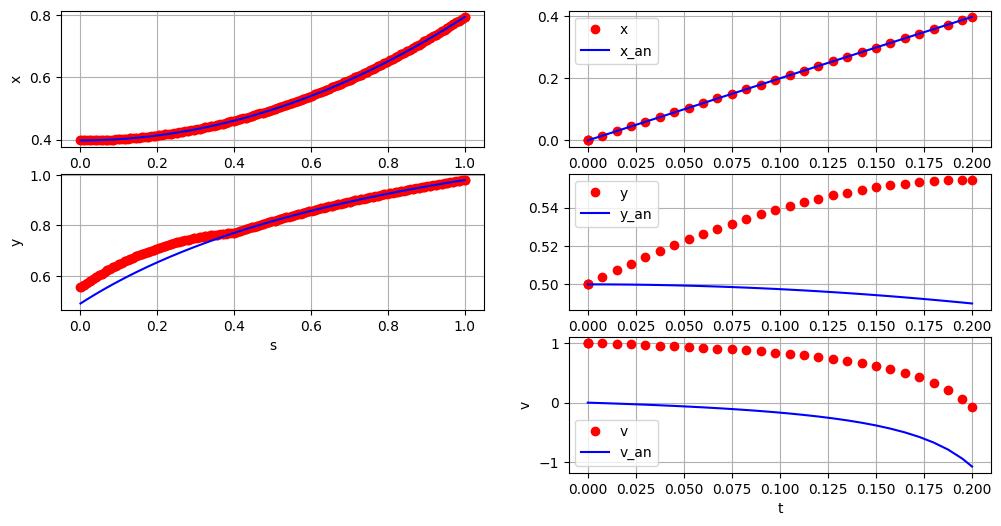

In [5]:
# Первое приближение ===============================================
# uk_0 = np.random.random(len(t_h))
G22_0 = lambda t: G22_true(t)+1
# G22_0 = lambda t: G22_true(t)
G21_0 = lambda t:  - G22_0(t)
hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])

solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)
plot_sys(mesh)

In [6]:
EPS = 0.00001
ULIM = [-2.5, 1]

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.9912183730190177e-06
        x: [ 3.276e-01  1.000e+00 ...  3.437e-02 -7.530e-02]
      nit: 4
      jac: [ 1.537e-06  0.000e+00 ...  1.096e-07  1.644e-08]
 hess_inv: [[ 3.657e+02  0.000e+00 ...  1.352e+01  1.991e+00]
            [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 1.352e+01  0.000e+00 ...  1.501e+00  7.383e-02]
            [ 1.991e+00  0.000e+00 ...  7.383e-02  1.011e+00]]
     nfev: 310
     njev: 10
{'max dx': 5.954998152146729e-06, 'max dy': 0.00788043693290802, 'max dv': 1.0, 'int dx^2 ds': 1.1243938118152601e-11, 'int dy^2 ds': 1.1243938118152601e-11, 'int dv^2 dt': 0.04772776305679285, 'time': 40.43355417251587}
t=t1:
	dx:5.954998152146729e-06
	dy:0.00788043693290802
s=s0:
	dx:4.651989349013785e-06 
	dy:0.00788043693290802


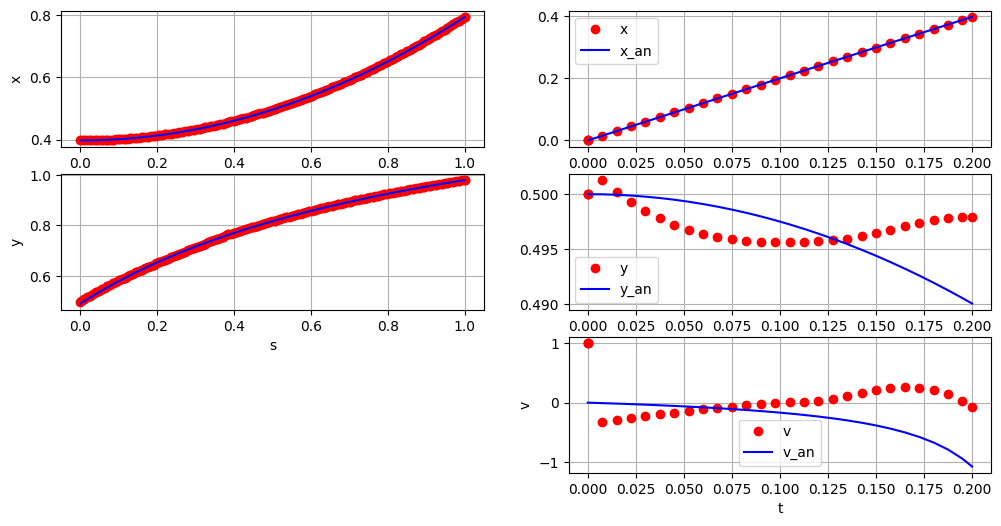

In [7]:
U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=True, method= "mpm")
rez_time = time()-start_time
rez_mpm = get_rez(rez) 
rez_mpm["time"] = rez_time
print(rez_mpm)
plot_sys(mesh)

Не оптимально
Невязка составляет: 0.007026
****************************************
результат минимизации a =  0.3225806451612903
Не оптимально
Невязка составляет: 0.000224
****************************************
результат минимизации a =  0.19230769230769232
Не оптимально
Невязка составляет: 0.000635
****************************************
результат минимизации a =  0.136986301369863
Не оптимально
Невязка составляет: 0.000534
****************************************
результат минимизации a =  0.13513513513513514
Не оптимально
Невязка составляет: 0.000086
****************************************
результат минимизации a =  0.10526315789473684
Не оптимально
Невязка составляет: 0.000376
****************************************
результат минимизации a =  0.08620689655172414
Не оптимально
Невязка составляет: 0.000313
****************************************
результат минимизации a =  0.08547008547008547
Не оптимально
Невязка составляет: 0.000065
****************************************
ре

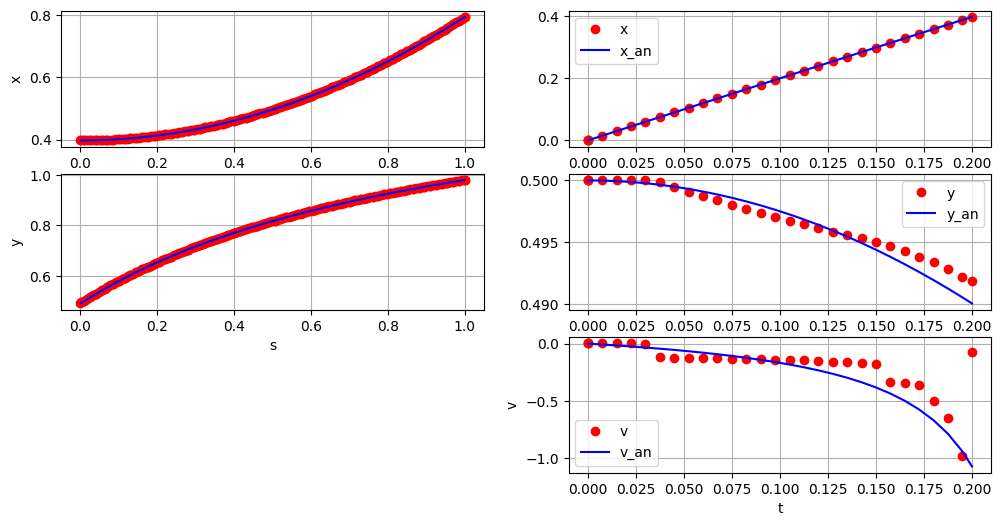

In [8]:
U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=True, method= "cgm")
rez_time = time()-start_time
rez_cgm = get_rez(rez) 
rez_cgm["time"] = rez_time
print(rez_cgm)
plot_sys(mesh)

Не оптимально
Невязка составляет: 0.007026
****************************************
результат минимизации a =  (0.625, 0.3448275862068966)
Не оптимально
Невязка составляет: 0.000185
****************************************
результат минимизации a =  (1.0, 0.20833333333333334)
Не оптимально
Невязка составляет: 0.000496
****************************************
результат минимизации a =  (0.625, 0.14705882352941177)
Не оптимально
Невязка составляет: 0.000567
****************************************
результат минимизации a =  (0.6666666666666666, 0.11363636363636363)
Не оптимально
Невязка составляет: 0.000192
****************************************
результат минимизации a =  (0.625, 0.11235955056179775)
Не оптимально
Невязка составляет: 0.000169
****************************************
результат минимизации a =  (0.625, 0.09174311926605505)
Не оптимально
Невязка составляет: 0.000356
****************************************
результат минимизации a =  (0.7142857142857143, 0.0775193798449612

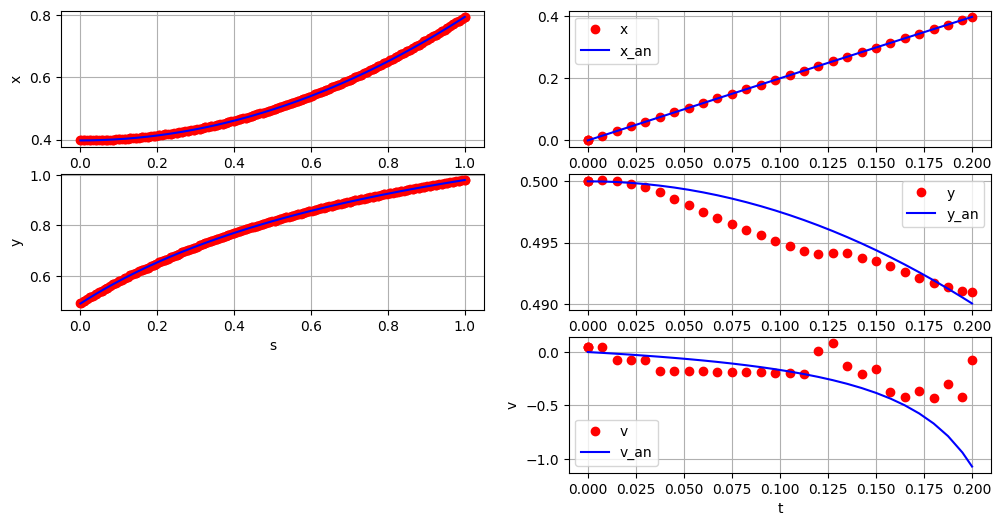

In [9]:
U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=True, method= "impm", beta = 0.0, delta = 1.0, eps_count_max=6)
rez_time = time()-start_time
rez_impm = get_rez(rez) 
rez_impm["time"] = rez_time
print(rez_impm)
plot_sys(mesh)

In [17]:
print("time \t max dx \t max dy \t max dv \t L2x    \t L2y    \t  L2v  \t")
for rez in [rez_mpm, rez_cgm, rez_impm]:
    print(f"{rez['time']:.1f}\t {rez['max dx']:.1e} \t{rez['max dy']:.1e} \t{rez['max dv']:.1e} \t{rez['int dx^2 ds']:.1e} \t{rez['int dy^2 ds']:.1e} \t{rez['int dv^2 dt']:.1e}")   

time 	 max dx 	 max dy 	 max dv 	 L2x    	 L2y    	  L2v  	
36.2	 7.0e-05 	2.9e-02 	2.1e+00 	8.2e-10 	8.2e-10 	2.8e-01
44.2	 6.0e-06 	2.7e-03 	2.1e+00 	1.2e-11 	1.2e-11 	1.6e-02
366.1	 5.0e-06 	4.6e-03 	2.1e+00 	9.7e-12 	9.7e-12 	3.2e-02


t=t1:
	dx:0.00011725348440938532
	dy:0.046741918020102746
s=s0:
	dx:1.572045454795168e-05 
	dy:0.03487786120059144


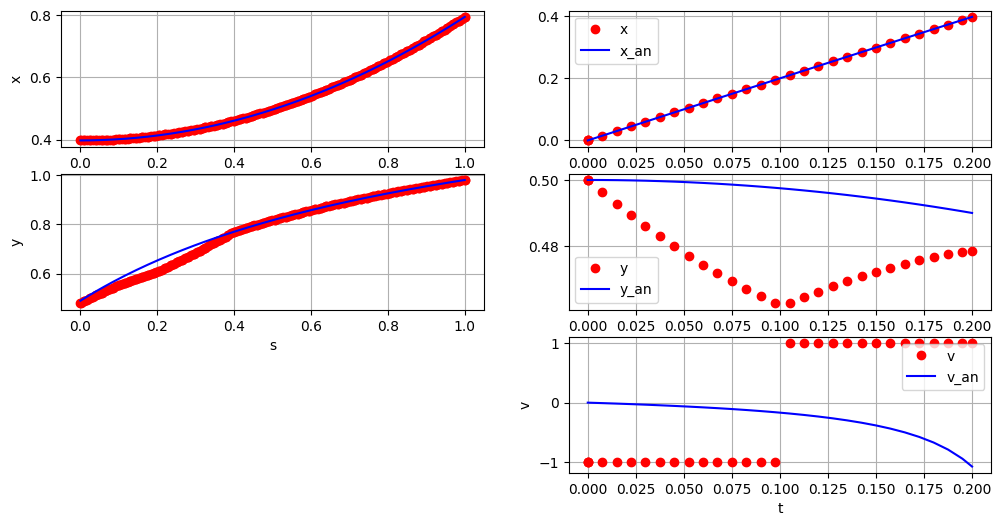

In [11]:
# Первое приближение ===============================================
# uk_0 = np.random.random(len(t_h))
G22_0 = lambda t: -1 if t < 0.1 else 1
# G22_0 = lambda t: G22_true(t)
G21_0 = lambda t:  - G22_0(t)
hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])

solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)
plot_sys(mesh)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 6.547073058290157e-06
        x: [-7.575e-01 -1.000e+00 ...  1.003e+00  1.000e+00]
      nit: 2
      jac: [-1.542e-06  0.000e+00 ...  1.103e-07  1.758e-08]
 hess_inv: [[ 5.705e+02  0.000e+00 ...  7.598e+00  9.962e-01]
            [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 7.598e+00  0.000e+00 ...  1.101e+00  1.329e-02]
            [ 9.962e-01  0.000e+00 ...  1.329e-02  1.002e+00]]
     nfev: 279
     njev: 9
{'max dx': 7.015285791506232e-05, 'max dy': 0.028827175693565743, 'max dv': 2.0720577595721266, 'int dx^2 ds': 8.213937926820393e-10, 'int dy^2 ds': 8.213937926820393e-10, 'int dv^2 dt': 0.28055940291473175, 'time': 36.20761775970459}
t=t1:
	dx:7.015285791506232e-05
	dy:0.028827175693565743
s=s0:
	dx:7.617764408607286e-06 
	dy:0.021510761704457593


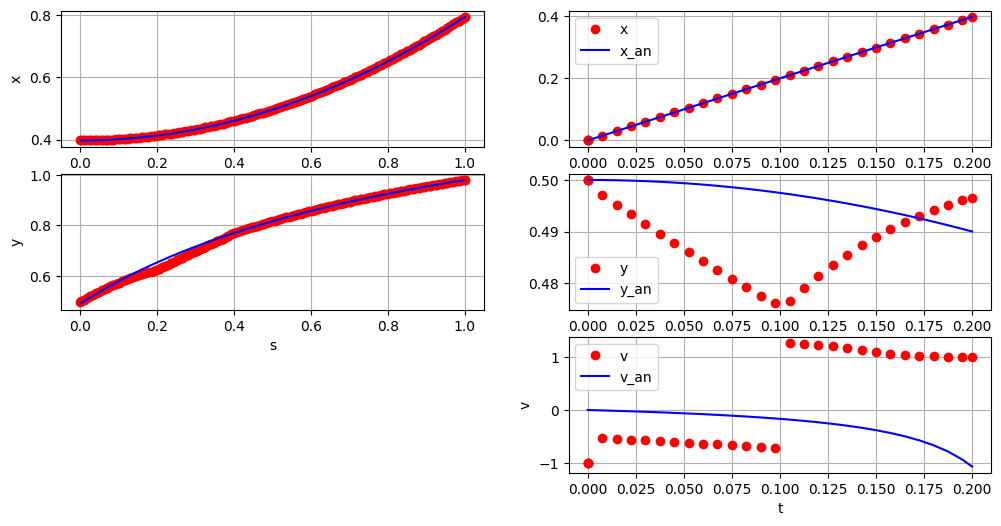

In [12]:
U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=True, method= "mpm")
rez_time = time()-start_time
rez_mpm = get_rez(rez) 
rez_mpm["time"] = rez_time
print(rez_mpm)
plot_sys(mesh)

Не оптимально
Невязка составляет: 0.001916
****************************************
результат минимизации a =  0.3225806451612903
Не оптимально
Невязка составляет: 0.000279
****************************************
результат минимизации a =  0.3125
Не оптимально
Невязка составляет: 0.000477
****************************************
результат минимизации a =  0.18867924528301888
Не оптимально
Невязка составляет: 0.001018
****************************************
результат минимизации a =  0.18518518518518517
Не оптимально
Невязка составляет: 0.000230
****************************************
результат минимизации a =  0.13333333333333333
Не оптимально
Невязка составляет: 0.000271
****************************************
результат минимизации a =  0.10416666666666667
Не оптимально
Невязка составляет: 0.000483
****************************************
результат минимизации a =  0.10309278350515463
Не оптимально
Невязка составляет: 0.000144
****************************************
результат мин

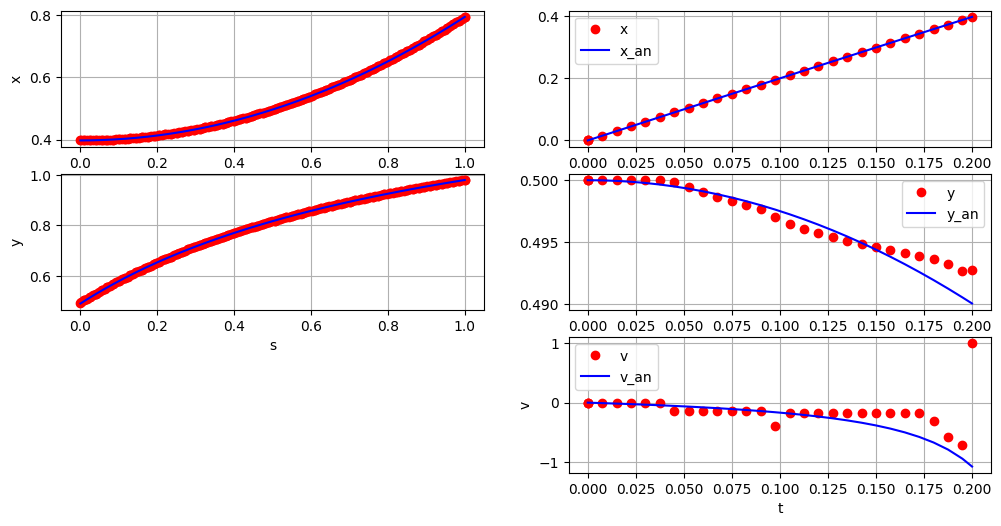

In [13]:
U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=True, method= "cgm")
rez_time = time()-start_time
rez_cgm = get_rez(rez) 
rez_cgm["time"] = rez_time
print(rez_cgm)
plot_sys(mesh)

Не оптимально
Невязка составляет: 0.001916
****************************************
результат минимизации a =  (1.0, 0.3333333333333333)
Не оптимально
Невязка составляет: 0.000262
****************************************
результат минимизации a =  (1.0, 0.2)
Не оптимально
Невязка составляет: 0.000166
****************************************
результат минимизации a =  (0.625, 0.19607843137254902)
Не оптимально
Невязка составляет: 0.000676
****************************************
результат минимизации a =  (0.625, 0.14084507042253522)
Не оптимально
Невязка составляет: 0.000197
****************************************
результат минимизации a =  (0.625, 0.1388888888888889)
Не оптимально
Невязка составляет: 0.000304
****************************************
результат минимизации a =  (0.625, 0.10869565217391304)
Не оптимально
Невязка составляет: 0.000443
****************************************
результат минимизации a =  (0.7692307692307693, 0.08928571428571429)
Не оптимально
Невязка составл

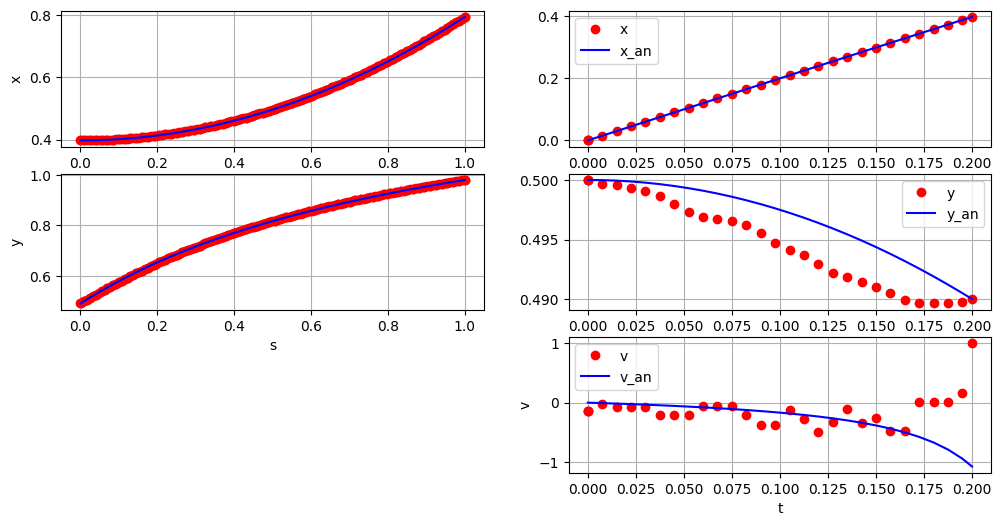

In [14]:
U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=True, method= "impm", beta = 0.0, delta = 1.0, eps_count_max=6)
rez_time = time()-start_time
rez_impm = get_rez(rez) 
rez_impm["time"] = rez_time
print(rez_impm)
plot_sys(mesh)

In [18]:
print("time \t max dx \t max dy \t max dv \t L2x    \t L2y    \t  L2v  \t")
for rez in [rez_mpm, rez_cgm, rez_impm]:
    print(f"{rez['time']:.1f}\t {rez['max dx']:.1e} \t{rez['max dy']:.1e} \t{rez['max dv']:.1e} \t{rez['int dx^2 ds']:.1e} \t{rez['int dy^2 ds']:.1e} \t{rez['int dv^2 dt']:.1e}")   

time 	 max dx 	 max dy 	 max dv 	 L2x    	 L2y    	  L2v  	
36.2	 7.0e-05 	2.9e-02 	2.1e+00 	8.2e-10 	8.2e-10 	2.8e-01
44.2	 6.0e-06 	2.7e-03 	2.1e+00 	1.2e-11 	1.2e-11 	1.6e-02
366.1	 5.0e-06 	4.6e-03 	2.1e+00 	9.7e-12 	9.7e-12 	3.2e-02


t=t1:
	dx:9.277658018447266e-06
	dy:0.008364053926475712
s=s0:
	dx:7.0186630757307356e-06 
	dy:0.008364053926475712


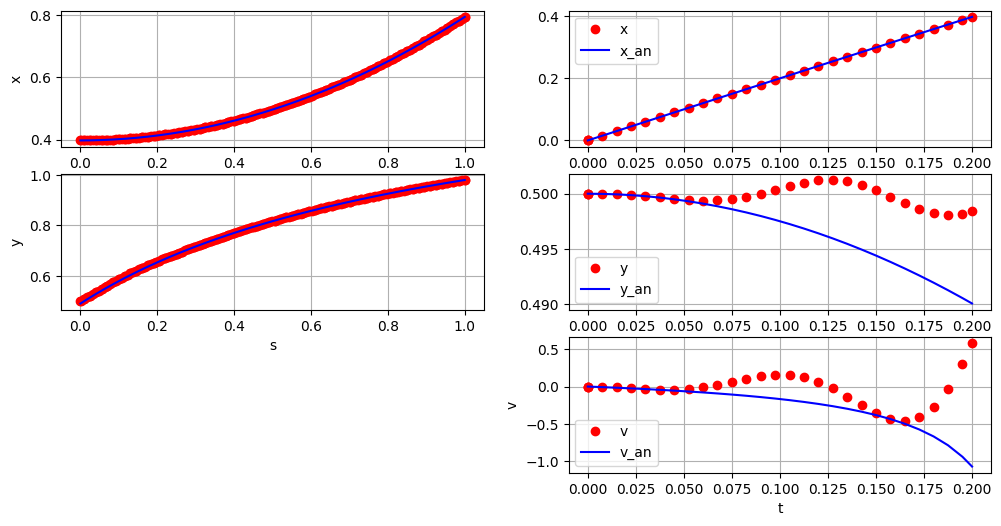

In [20]:
# Первое приближение ===============================================
# uk_0 = np.random.random(len(t_h))
G22_0 = lambda t: G22_true(t)*np.sin(t*50)
# G22_0 = lambda t: G22_true(t)
G21_0 = lambda t:  - G22_0(t)
hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])

solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)
plot_sys(mesh)

In [21]:
U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez31 = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=False, method= "mpm")
rez_time = time()-start_time
rez_mpm = get_rez(rez31) 
rez_mpm["time"] = rez_time
print(rez_mpm)

U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez32 = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=False, method= "cgm")
rez_time = time()-start_time
rez_cgm = get_rez(rez32) 
rez_cgm["time"] = rez_time
print(rez_cgm)

U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez33 = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=False, method= "impm", beta = 0.0, delta = 1.0, eps_count_max=6)
rez_time = time()-start_time
rez_impm = get_rez(rez33) 
rez_impm["time"] = rez_time
print(rez_impm)




  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.156282388204445e-06
        x: [-0.000e+00 -0.000e+00 ...  3.006e-01  5.830e-01]
      nit: 0
      jac: [ 4.291e-06  0.000e+00 ...  1.397e-07  2.116e-08]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 31
     njev: 1
{'max dx': 9.277658018447266e-06, 'max dy': 0.008364053926475712, 'max dv': 1.6546247051629894, 'int dx^2 ds': 2.2602230867422215e-11, 'int dy^2 ds': 2.2602230867422215e-11, 'int dv^2 dt': 0.027168778574132038, 'time': 4.227271795272827}
{'max dx': 7.937495222321012e-06, 'max dy': 0.004634113326012601, 'max dv': 1.6546247051629894, 'int dx^2 ds': 1.4658634450614536e-11, 'int dy^2 ds': 1.4658634450614536e-11, 'int dv^2 dt': 0.009512459578174653, 'time': 47.748653411865234}
{'max dx': 7.834009737195391e-06, 'max dy': 0.0019365447830973492, 'max dv': 1.6546247051629894, 'int dx^2 ds': 2.050000727391501

In [22]:
print("time \t max dx \t max dy \t max dv \t L2x    \t L2y    \t  L2v  \t")
for rez in [rez_mpm, rez_cgm, rez_impm]:
    print(f"{rez['time']:.1f}\t {rez['max dx']:.1e} \t{rez['max dy']:.1e} \t{rez['max dv']:.1e} \t{rez['int dx^2 ds']:.1e} \t{rez['int dy^2 ds']:.1e} \t{rez['int dv^2 dt']:.1e}")   

time 	 max dx 	 max dy 	 max dv 	 L2x    	 L2y    	  L2v  	
4.2	 9.3e-06 	8.4e-03 	1.7e+00 	2.3e-11 	2.3e-11 	2.7e-02
47.7	 7.9e-06 	4.6e-03 	1.7e+00 	1.5e-11 	1.5e-11 	9.5e-03
368.9	 7.8e-06 	1.9e-03 	1.7e+00 	2.1e-11 	2.1e-11 	1.5e-02


t=t1:
	dx:9.514307589331139e-06
	dy:0.009966711079379187
s=s0:
	dx:7.153307310714396e-06 
	dy:0.009966711079379187


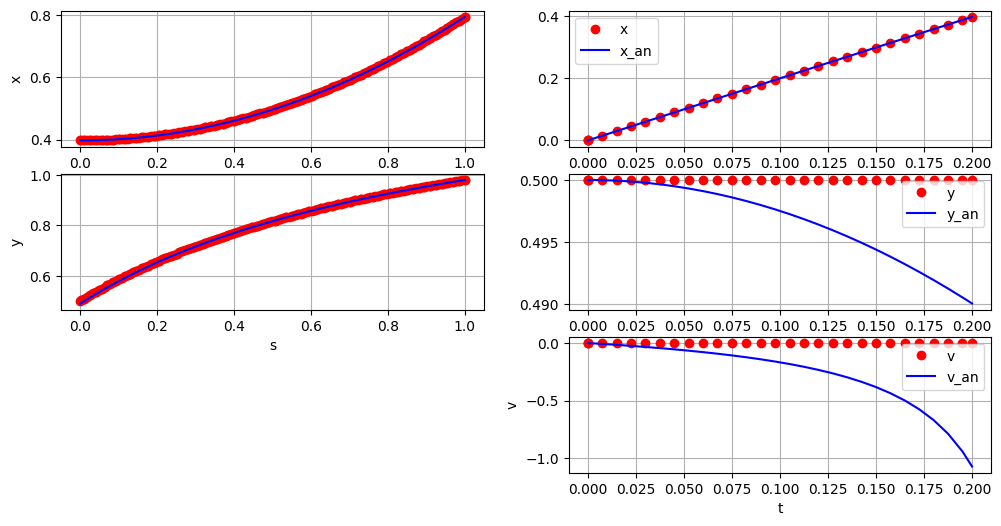

In [23]:
# Первое приближение ===============================================
# uk_0 = np.random.random(len(t_h))
G22_0 = lambda t: 0
# G22_0 = lambda t: G22_true(t)
G21_0 = lambda t:  - G22_0(t)
hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])

solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)
plot_sys(mesh)

In [24]:
U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez31 = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=False, method= "mpm")
rez_time = time()-start_time
rez_mpm = get_rez(rez31) 
rez_mpm["time"] = rez_time
print(rez_mpm)

U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez32 = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=False, method= "cgm")
rez_time = time()-start_time
rez_cgm = get_rez(rez32) 
rez_cgm["time"] = rez_time
print(rez_cgm)

U0 = G22_0
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez33 = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=False, method= "impm", beta = 0.0, delta = 1.0, eps_count_max=6)
rez_time = time()-start_time
rez_impm = get_rez(rez33) 
rez_impm["time"] = rez_time
print(rez_impm)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 8.606130462573003e-06
        x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
      nit: 0
      jac: [ 4.604e-06  0.000e+00 ...  1.735e-07  2.558e-08]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 31
     njev: 1
{'max dx': 9.514307589331139e-06, 'max dy': 0.009966711079379187, 'max dv': 1.0716334728156087, 'int dx^2 ds': 2.6201009827015388e-11, 'int dy^2 ds': 2.6201009827015388e-11, 'int dv^2 dt': 0.027010260204047346, 'time': 4.222579479217529}
{'max dx': 7.750749549451097e-06, 'max dy': 0.004657085590574872, 'max dv': 1.0716334728156087, 'int dx^2 ds': 1.4297145910315943e-11, 'int dy^2 ds': 1.4297145910315943e-11, 'int dv^2 dt': 0.004834950082166317, 'time': 47.450080156326294}
{'max dx': 6.908598162547186e-06, 'max dy': 0.002039728069883062, 'max dv': 1.0716334728156087, 'int dx^2 ds': 1.729117509411335e

In [25]:
print("time \t max dx \t max dy \t max dv \t L2x    \t L2y    \t  L2v  \t")
for rez in [rez_mpm, rez_cgm, rez_impm]:
    print(f"{rez['time']:.1f}\t {rez['max dx']:.1e} \t{rez['max dy']:.1e} \t{rez['max dv']:.1e} \t{rez['int dx^2 ds']:.1e} \t{rez['int dy^2 ds']:.1e} \t{rez['int dv^2 dt']:.1e}")   

time 	 max dx 	 max dy 	 max dv 	 L2x    	 L2y    	  L2v  	
4.2	 9.5e-06 	1.0e-02 	1.1e+00 	2.6e-11 	2.6e-11 	2.7e-02
47.5	 7.8e-06 	4.7e-03 	1.1e+00 	1.4e-11 	1.4e-11 	4.8e-03
374.6	 6.9e-06 	2.0e-03 	1.1e+00 	1.7e-11 	1.7e-11 	8.3e-03
